In [1]:
import torch
from torchvision.transforms import transforms
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import json
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os


In [2]:
# Load OCR Model
class CNN(torch.nn.Module):
    def __init__(self, in_size=(200, 50, 1), conv_out_1=32, conv_kern_1=3, conv_out_2=64,
                 conv_kern_2=3, fc1_out=64, lstm1_out=128, lstm2_out=64, fc2_out=38):
        super(CNN, self).__init__()
        w, h, c = in_size
        self.conv1 = torch.nn.Conv2d(c, conv_out_1, kernel_size=conv_kern_1, padding="same")
        self.conv2 = torch.nn.Conv2d(conv_out_1, conv_out_2, kernel_size=conv_kern_2, padding="same")
        self.fc1 = torch.nn.Linear(conv_out_2, fc1_out)
        self.lstm1 = torch.nn.LSTM(fc1_out * (h // 4), lstm1_out, bidirectional=True, batch_first=True)
        self.lstm2 = torch.nn.LSTM(lstm1_out * 2, lstm2_out, bidirectional=True, batch_first=True)
        self.fc2 = torch.nn.Linear(lstm2_out * 2, fc2_out)

    def forward(self, x):
        batch_size, c, h, w = x.shape
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.permute(0, 3, 2, 1)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.2, train=False)
        x = x.reshape(batch_size, w // 4, -1)
        x, _ = self.lstm1(x)
        x = torch.dropout(x, p=0.25, train=False)
        x, _ = self.lstm2(x)
        x = torch.dropout(x, p=0.25, train=False)
        x = torch.log_softmax(self.fc2(x), dim=-1)
        return x.permute(1, 0, 2)

In [3]:
# Load OCR Model and Classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# weights_path = "path_to_your_saved_weights.pth"  
# ocr_model.load_state_dict(torch.load(weights_path))
# ocr_model = torch.load("/home/infres/lotfi-23/training/model_last.pth")
ocr_model = torch.load("/home/infres/lotfi-23/notebooks/saved_models2/model_epoch_100.pth")
ocr_model = ocr_model.to(device)
ocr_model.eval()

with open("/home/infres/lotfi-23/notebooks/classes.json", "r") as f: # replace with you classes.json path
    classes = json.load(f)

# Load YOLO Model
yolo_model = YOLO("/home/infres/lotfi-23/notebooks/runs/detect/train7/weights/best.pt") # Load the saved yolomodel in run directory

# Define OCR transforms
ocr_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

# Decode OCR predictions
def decode_predictions(predictions, classes):
    pred_str = ''.join([classes[c - 1] if c != 0 else '_' for c in predictions])
    pred_str = ''.join(ch for i, ch in enumerate(pred_str) if ch != '_' and (i == 0 or ch != pred_str[i - 1]))
    return pred_str


In [4]:
# # Perform inference and visualize results

# from PIL import Image, ImageDraw, ImageFont
# def detect_and_visualize(image_path, yolo_model, ocr_model, ocr_transforms, classes, device, save_path=None):
#     """
#     Detect license plates in an image using YOLO, recognize text using OCR, and display/save results.

#     Args:
#         image_path (str): Path to the input image.
#         yolo_model: YOLO model for license plate detection.
#         ocr_model: OCR model for plate text recognition.
#         ocr_transforms: Preprocessing pipeline for OCR.
#         classes (list): Character mapping used during OCR training.
#         device: Torch device (CPU or GPU).
#         save (bool): Whether to save the output image with bounding boxes. Default is False.
#         save_path (str): Path to save the output image. Default is "output_with_bounding_boxes.jpg".
#     """
#         # Load and prepare the image
#     image = cv2.imread(image_path)
#     if image is None:
#         raise ValueError(f"Could not read image at {image_path}")
#     original_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     draw = ImageDraw.Draw(original_image)

#     # Set font for the text
#     try:
#         font = ImageFont.truetype("C:/USERS/DC/APPDATA/LOCAL/MICROSOFT/WINDOWS/FONTS/ROBOTO-REGULAR.TTF", size=50)
#     except IOError:
#         print('font not loaded, using default font')
#         font = ImageFont.load_default()

#     # Detect license plates using YOLO
#     results = yolo_model(image)
#     for box in results[0].boxes.xyxy.cpu().numpy():
#         x_min, y_min, x_max, y_max = map(int, box)

#         # Crop the license plate
#         plate_image = image[y_min:y_max, x_min:x_max]
#         plate_image_pil = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)).convert('L')
#         plate_image_resized = plate_image_pil.resize((200, 50))
#         plate_tensor = ocr_transforms(plate_image_resized).unsqueeze(0).to(device)

#         # Recognize text using OCR
#         with torch.no_grad():
#             outputs = ocr_model(plate_tensor)
#             predictions = outputs.argmax(dim=-1).cpu().numpy()[:, 0]
#         plate_text = decode_predictions(predictions, classes)

#         # Draw bounding box and recognized text
#         draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
#         text_bbox = draw.textbbox((x_min, y_min - 20), plate_text, font=font)  # Get text bounding box
#         draw.rectangle(text_bbox, fill="red")  # Background for text
#         draw.text((text_bbox[0], text_bbox[1]), plate_text, fill="white", font=font)

#     # Save the output image (optional)
#     if save_path:
#         original_image.save(save_path)
#         print(f"Saved visualization at {save_path}")

#     # Display the output using matplotlib
#     plt.figure(figsize=(12, 8))  # Set figure size to make the image larger
#     plt.imshow(original_image)
#     plt.axis('off')
#     plt.show()


# def detect_and_visualize(image_path, yolo_model, ocr_model, ocr_transforms, classes, device, save_path=None):
#     # Load the image
#     image = cv2.imread(image_path)
#     if image is None:
#         raise ValueError(f"Could not read image at {image_path}")

#     # Run YOLO detection
#     results = yolo_model(image)
#     boxes = results[0].boxes

#     if len(boxes) == 0:
#         print("No license plates detected.")
#         return

#     # Convert the image to RGB for plt visualization
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Initialize a plt figure
#     plt.figure(figsize=(12, 8))
#     plt.imshow(image_rgb)
#     ax = plt.gca()

#     for box in boxes:
#         # Extract bounding box coordinates
#         x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy())
#         plate_image = image[y_min:y_max, x_min:x_max]

#         # Preprocess plate image for OCR
#         plate_image_pil = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)).convert('L')
#         plate_image_resized = plate_image_pil.resize((200, 50))
#         plate_tensor = ocr_transforms(plate_image_resized).unsqueeze(0).to(device)

#         # Perform OCR
#         with torch.no_grad():
#             outputs = ocr_model(plate_tensor)
#             predictions = outputs.argmax(dim=-1).cpu().numpy()[:, 0]
#         plate_text = decode_predictions(predictions, classes)

#         # Draw bounding box
#         ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                linewidth=2, edgecolor='red', facecolor='none'))

#         # Add text above the bounding box
#         ax.text(x_min, y_min - 10, plate_text, color='red', fontsize=15,
#                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

#     # Save or display the result
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight')
#         print(f"Image saved at {save_path}")
#     else:
#         plt.show()



def detect_and_visualize(image_path, yolo_model, ocr_model, ocr_transforms, classes, device, save_path=None):
    """
    Detect and visualize license plates in an image, showing bounding boxes,
    detected plate text, and confidence scores.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Run YOLO detection
    results = yolo_model(image)
    boxes = results[0].boxes

    if len(boxes) == 0:
        print("No license plates detected.")
        return

    # Convert the image to RGB for plt visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize a plt figure
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    ax = plt.gca()

    for box in boxes:
        # Extract bounding box coordinates
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy())
        plate_image = image[y_min:y_max, x_min:x_max]

        # Preprocess plate image for OCR
        plate_image_pil = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)).convert('L')
        plate_image_resized = plate_image_pil.resize((200, 50))
        plate_tensor = ocr_transforms(plate_image_resized).unsqueeze(0).to(device)

        # Perform OCR
        with torch.no_grad():
            outputs = ocr_model(plate_tensor)
            probabilities = torch.exp(outputs)  # Convert log-softmax to probabilities
            predictions = outputs.argmax(dim=-1).cpu().numpy()[:, 0]
        plate_text = decode_predictions(predictions, classes)
        print(predictions)
        print(len(predictions))

        # print(f"Outputs shape: {outputs.shape}")
        # print(f"Probabilities range: min={probabilities.min().item()}, max={probabilities.max().item()}")

        # Log character confidences
        # char_confidences = [(classes[c-1], probabilities[0, :, c].max().item()) for c in predictions if c != 0]
        char_confidences1 = []
        for t, c in enumerate(predictions):
            if c != 0 and c <= len(classes):  # Ignore blank index
                char = classes[c - 1]  # Map to the corresponding character
                confidence = probabilities[t, 0, c].item()  # Confidence for this character
                char_confidences1.append((char, confidence))
        
        
        # Map confidences to the final plate text
        char_confidences = []
        prediction_idx = 0  # Pointer for predictions

        for char in plate_text:
            while prediction_idx < len(predictions):
                pred_char_idx = predictions[prediction_idx]
                if pred_char_idx != 0:  # Ignore blanks
                    matched_char = classes[pred_char_idx - 1]
                    if matched_char == char:
                        confidence = probabilities[prediction_idx, 0, pred_char_idx].item()
                        char_confidences.append((char, confidence))
                        prediction_idx += 1
                        break
                prediction_idx += 1


        # char_confidences = {classes[c]: probabilities[t, 0, c].item()
        #             for t, c in enumerate(predictions) if c <= len(classes)}
        # char_confidences = []
        # for t, c in enumerate(predictions):
        #     if c != 0 and c <= len(classes):  # Ignore blank and invalid indices
        #         char_confidences.append({
        #             'char': classes[c - 1],
        #             'confidence': probabilities[t, 0, c].item()
        #         })
        print(f'Bounding Box Confidence: {box.conf[0]:.2f}')
        print(f"Plate text: {plate_text}")
        # print(f"Character confidences: {char_confidences1}")
        print(f"Final Character confidences: {char_confidences}")

        # Draw bounding box
        ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                               linewidth=2, edgecolor='red', facecolor='none'))

        # Add text above the bounding box
        confidence_text = f"{plate_text} ({box.conf[0]:.2f})"
        ax.text(x_min, y_min - 15, confidence_text, color='red', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

    # Save or display the result
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Image saved at {save_path}")
    else:
        plt.show()



0: 640x480 1 کل ناحیه پلاک, 58.9ms
Speed: 10.4ms preprocess, 58.9ms inference, 148.3ms postprocess per image at shape (1, 3, 640, 480)
[34  0  0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  9  0  0  0  0  0  0  0  0 33  0  0  0  0 33  0  0  0  0 26  0  0  0  0 34  0  0  0  0 34  0  0]
50
Bounding Box Confidence: 0.87
Plate text: 95M88199
Final Character confidences: [('9', 0.9998885989189148), ('5', 0.9999946355819702), ('M', 0.9999825954437256), ('8', 0.9999940991401672), ('8', 0.9999876618385315), ('1', 0.999995231628418), ('9', 0.999962329864502), ('9', 0.9999874830245972)]


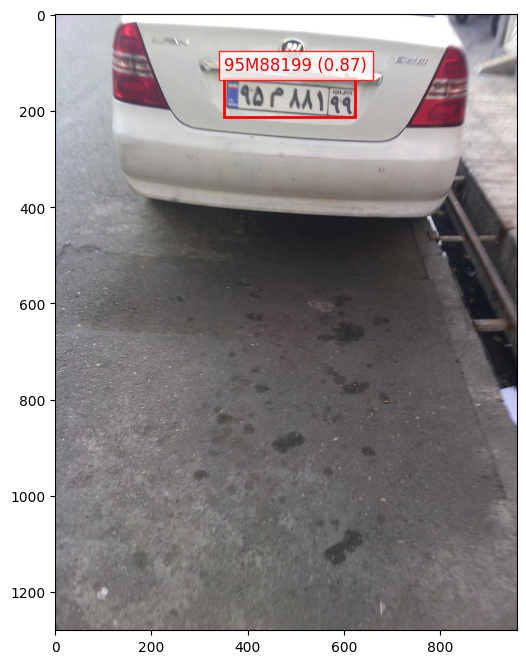

In [5]:
# Example Usage
image_path = "/home/infres/lotfi-23/test/Images/day_00019.jpg"  # Replace with the path to your test image
save_path = "output_with_bounding_boxes1.jpg"  # Replace or set to None to only display
detect_and_visualize(image_path, yolo_model, ocr_model, ocr_transforms, classes, device)

In [6]:
def process_input(input_path, yolo_model, ocr_model, ocr_transforms, classes, device, output_path=None):
    """
    Wrapper function to handle both images and videos.
    Args:
        input_path (str): Path to the input file (image or video).
        yolo_model: YOLO model for license plate detection.
        ocr_model: OCR model for character recognition.
        ocr_transforms: Transformations for the OCR model.
        classes: Character classes used in OCR.
        device: Torch device for inference.
        output_path (str): Path to save the output (optional).
    """
    if os.path.isfile(input_path):
        # Determine if the input is an image or video
        ext = os.path.splitext(input_path)[-1].lower()
        if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            # Handle image
            print(f"Processing image: {input_path}")
            detect_and_visualize(input_path, yolo_model, ocr_model, ocr_transforms, classes, device, save_path=output_path)
        elif ext in ['.mp4', '.avi', '.mov', '.mkv']:
            # Handle video
            print(f"Processing video: {input_path}")
            process_video(input_path, yolo_model, ocr_model, ocr_transforms, classes, device, output_video_path=output_path)
        else:
            print(f"Unsupported file type: {ext}")
    else:
        print(f"File not found: {input_path}")

def process_video(video_path, yolo_model, ocr_model, ocr_transforms, classes, device, output_video_path=None):
    """
    Process video input using the existing detect_and_visualize pipeline for each frame.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video {video_path}")
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if output_video_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save the frame temporarily to pass it to detect_and_visualize
        temp_image_path = f"temp_frame_{frame_count}.jpg"
        cv2.imwrite(temp_image_path, frame)

        # Run detection and visualization
        temp_output_path = f"temp_output_frame_{frame_count}.jpg" if output_video_path else None
        detect_and_visualize(temp_image_path, yolo_model, ocr_model, ocr_transforms, classes, device, save_path=temp_output_path)

        if output_video_path:
            # Read back the processed frame and write it to the video
            processed_frame = cv2.imread(temp_output_path)
            out.write(processed_frame)

            # Cleanup temporary files
            os.remove(temp_output_path)

        # Cleanup the input temporary frame
        os.remove(temp_image_path)

        frame_count += 1

        # Display the processed frame
        if not output_video_path:
            cv2.imshow("Processed Frame", processed_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if output_video_path:
        out.release()
    cv2.destroyAllWindows()


Processing image: /home/infres/lotfi-23/test/Images/day_14002.jpg



0: 480x640 4 کل ناحیه پلاکs, 46.2ms
Speed: 1.7ms preprocess, 46.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
[30  0  0  0  0  0  0  0  0  0  0  0  0 34  0  0  0  0  7  0  0  0  0  0  0  0  0 32  0  0  0 34 34  0  0  0 33  0  0  0  0  0 33  0  0  0  0 33  0  0]
50
Bounding Box Confidence: 0.84
Plate text: 59Q79888
Final Character confidences: [('5', 0.9998300671577454), ('9', 0.9999900460243225), ('Q', 0.9999489784240723), ('7', 0.9999340772628784), ('9', 0.9999810457229614), ('8', 0.9999969005584717), ('8', 0.9999849796295166), ('8', 0.9999818801879883)]
[27  0  0  0  0  0  0  0  0  0  0  0  0 27  0  0  0  0  7  0  0  0  0  0  0  0  0 34  0  0  0  0 29  0  0  0  0 33  0  0  0  0  0 30  0  0  0 29  0  0]
50
Bounding Box Confidence: 0.83
Plate text: 22Q94854
Final Character confidences: [('2', 0.9969905614852905), ('2', 0.9998019337654114), ('Q', 0.9995998740196228), ('9', 0.9999783039093018), ('4', 0.9993379712104797), ('8', 0.9999955892562866), ('5', 0.999879181

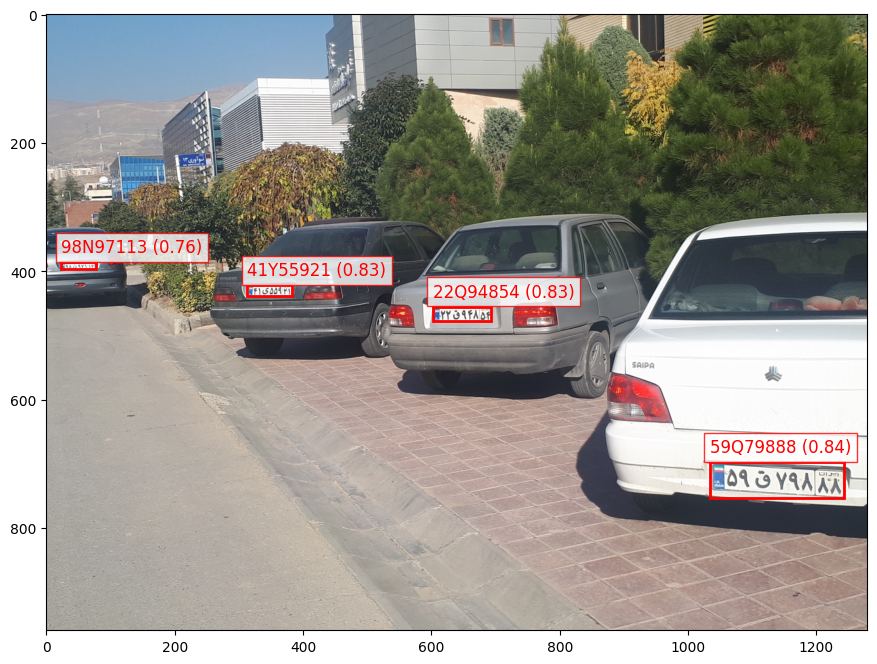

In [7]:
# For multiple plates in an image

image_path = "/home/infres/lotfi-23/test/Images/day_14002.jpg"  # Replace with the path to your test image
save_path = "output_with_bounding_boxes1.jpg"  # Replace or set to None to only display

process_input(
    input_path=image_path,
    yolo_model=yolo_model,
    ocr_model=ocr_model,
    ocr_transforms=ocr_transforms,
    classes=classes,
    device=device,
    output_path=None
)